### Variables

Master number: Internal customer identification number in the bank system

Target Variable: Customer completed the product in the campaign

Day: Call day of the call center agent

Month: month of call of the call center agent

Duration: duration of the call

Call ID: Internal call identification number

Age: age of the customer

Gender: Customer's gender

Type of employment: type of employment of the customer

Marital status: Marital status of the customer

Credit Failure: Customer has a defaulted loan in the bank

Account balance: Current account balance of the customer in his checking account

House: Customer has property

Credit: Customer has a loan in the bank

Contact type: In this way the customer was contacted

Number of speeches: The number of times the customer was addressed has already been addressed in this campaign

Days since last campaign: so many days ago, the customer was addressed in the campaign

Number of contacts last campaign: The number of times the customer was approached during the last campaign

Result last campaign: result of last campaign

## Imports

## We import all the libraries before we start building the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Functions

## We build functions for all the processes in the model so as to achieve proper accuracy.

In [155]:
def process_df(filepath):
    """load the dataset into the system using pandas.read_csv function
    
    Parameters:
    filepath: Path to the dataset
    
    Returns:
    df: Generated dataframe"""
    df=pd.read_csv(filepath, encoding='ISO-8859-1')

    if df['Zielvariable'].isnull().all():
        df = df.drop('Zielvariable', axis=1)
    else:
        m = {'ja' : 1, 'nein' : 0}
        df['Zielvariable'] = df['Zielvariable'].str.lower().map(m)
        
            
    df.shape
    #Rename column names to lowercase with and _ instead of space
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    
    #Drop columns with errors Note: These columns are dropped after initial analysis like missing values etc
    df = df.drop(['tage_seit_letzter_kampagne','anruf-id','kontostand','geschlecht','anzahl_kontakte_letzte_kampagne'], axis=1)
    
    #Process categorical variables
    df = pd.get_dummies(df)
    
    return df

def feature_selection(df):
    """"Feature selection based on the scores of features from PCA
    
    Parameters:
    df: Dataframe
    n: Number of features to be kept based on the plot
    
    Returns:
    df: Generated dataframe"""
    
    if 'zielvariable' in df.columns:
        X=df.drop('zielvariable',axis=1)
        y=df['zielvariable']
    else:
        X = df
    n = len(X.columns)
    #Scaling the values
    X = scale(X)
    
    # Prinicipal component analysis on the dataset
    pca = PCA(n_components=n)
    pca.fit(X)

    #The amount of variance that each PC explains
    var= pca.explained_variance_ratio_

    #Cumulative Variance explains
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    c = [i for i in var1 if i<100]
    c = len(c)
    plt.plot(var1)
    
    pca = PCA(n_components=c)
    pca.fit(X)
    X = pca.fit_transform(X)
    
    return X

def oversampling(X, y):
    """We know from intial analysis that the target variable has imbalanced class. 
    Hence we use Smote tomek method to oversample and then undersample the dataset inorder to get balanced class.
    
    Parameters:
    X: Feature set
    y: Response variable
    
    Returns:
    X: Feature set
    y: Response variable
    """
    smt = SMOTETomek(ratio='auto')
    X, y = smt.fit_sample(X, y)
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title('Oversampling using Smote + Tomek Links')
    plt.legend(loc='upper right')
    plt.show()
    return X, y

def generate_model(X,y, df_test, classifier):
    
    """ Function to generate machine learning model and return auc score,  and predicted output
        
        Parameters:
        X_train, X_test, y_train, y_test: train test split
        regressor: the regression algorithm to be used
        
        Returns:
        score: machine learning score of the model
        mae: mean absolute error
        y_preds: prediction output
    """
    
    # Splitting dataset into train set and test set
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=42)

    classifier.fit(X_train,y_train)
    y_pred = classifier.predict_proba(X_test)
    y_pred_new = classifier.predict_proba(df_test)
    results = y_pred_new[:,1]

    y_pred = y_pred[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% auc_score)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();
    
    return auc, y_pred, results

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[  8.08  13.93  18.92  23.71  27.99  31.92  35.45  38.61  41.6   44.36
  46.99  49.53  51.98  54.37  56.72  59.01  61.27  63.5   65.69  67.82
  69.93  72.03  74.11  76.18  78.23  80.26  82.23  84.12  85.98  87.81
  89.61  91.29  92.93  94.48  95.99  97.12  98.07  98.99  99.82 100.01
 100.01 100.01 100.01 100.01 100.01 100.01 100.01 100.01 100.01]
[  8.05  13.94  18.95  23.76  28.04  31.95  35.47  38.67  41.68  44.47
  47.12  49.64  52.13  54.53  56.9   59.18  61.44  63.66  65.84  68.01
  70.13  72.23  74.29  76.34  78.38  80.38  82.32  84.22  86.08  87.91
  89.66  91.32  92.95  94.47  95.97  97.12  98.07  98.97  99.81 100.01
 100.01 100.01 100.01 100.01 100.01 100.01 100.01 100.01 100.01]


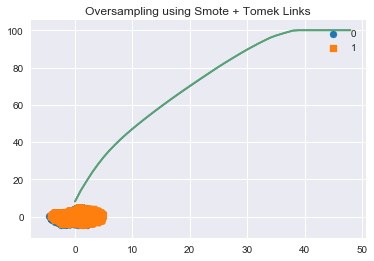

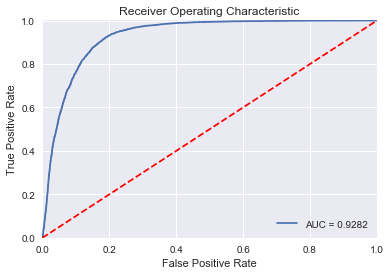

LogisticRegression <function auc at 0x000001ED9E2AF7B8>


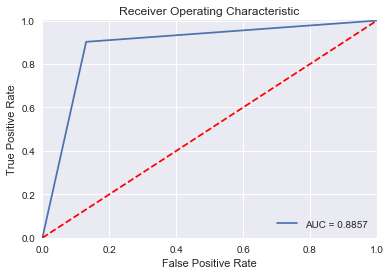

DecisionTreeClassifier <function auc at 0x000001ED9E2AF7B8>


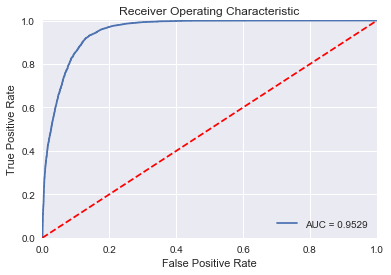

RandomForestClassifier <function auc at 0x000001ED9E2AF7B8>


In [159]:
def test_model(filepath1, filepath2):
    """ load dataset, build feature set, and do learning
        
        Parameters:
        filepath: file name of dataset
        
        Returns:
        predictions saved to files
    """
    df = process_df(filepath1)
    df_test = process_df(filepath2)
    
    X = feature_selection(df)
    X_predict = feature_selection(df_test)
    
    y=df['zielvariable']
    
    X, y = oversampling(X,y)
    
    for i, classifier in enumerate((
        LogisticRegression(C=0.1, random_state=5),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(criterion='entropy',class_weight='balanced',n_estimators=200,
                               n_jobs=-1,max_features='auto', min_samples_leaf=2, min_samples_split=2, max_depth=10))):
        auc_score, y_preds, results = generate_model(X, y, X_predict, classifier)
        rname = str(classifier).split('(')[0]
        print(rname, auc_score)
        results = pd.DataFrame({'ID': df_test.loc[:,'stammnummer'], 'expected': results})
        results.to_csv('E:\\Personal\\tasks\\Medtrust\\results.csv', index = False, columns=['ID','expected'])
    

if __name__ == "__main__":
    test_model('E:\\Personal\\tasks\\Medtrust\\TrainData.csv', 'E:\\Personal\\tasks\\Medtrust\\TestData.csv')